<a href="https://colab.research.google.com/github/plthiyagu/AI-Engineering/blob/master/07-Machine%20Learning/Cross_Sell_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install imblearn
from sklearn.metrics import accuracy_score, f1_score,auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/Cross_Sell.csv")
df.shape

(381109, 12)

In [3]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [5]:
df.isna()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,False,False,False,False,False,False,False,False,False,False,False,False
381105,False,False,False,False,False,False,False,False,False,False,False,False
381106,False,False,False,False,False,False,False,False,False,False,False,False
381107,False,False,False,False,False,False,False,False,False,False,False,False


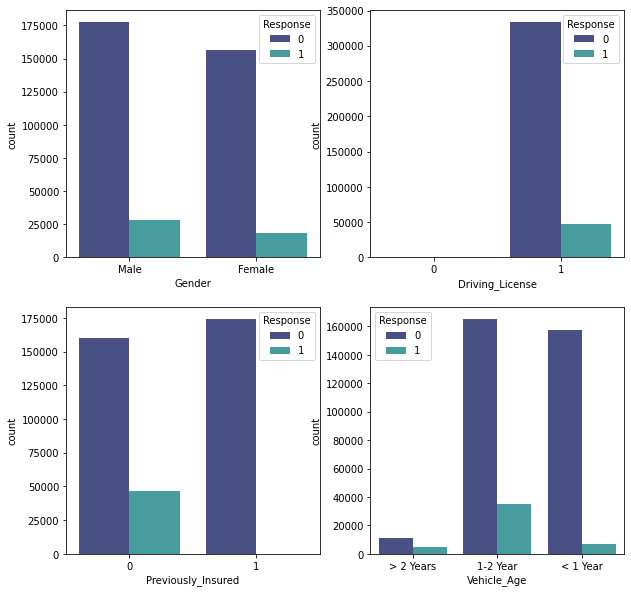

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10)) 

sns.countplot(ax=axes[0,0],x='Gender',hue='Response',data=df,palette="mako") 
sns.countplot(ax=axes[0,1],x='Driving_License',hue='Response',data=df,palette="mako") 
sns.countplot(ax=axes[1,0],x='Previously_Insured',hue='Response',data=df,palette="mako") 
sns.countplot(ax=axes[1,1],x='Vehicle_Age',hue='Response',data=df,palette="mako")


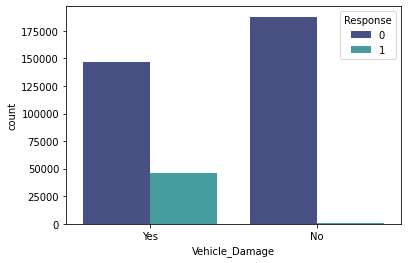

In [7]:
sns.countplot(x='Vehicle_Damage',hue='Response',data=df,palette="mako")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


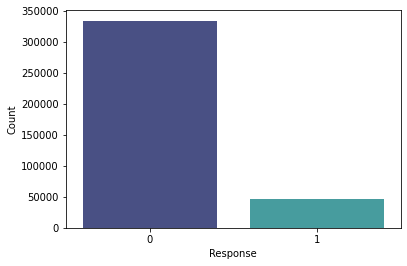

In [8]:
Response = df.loc[:,"Response"].value_counts().rename('Count')
plt.xlabel("Response")
plt.ylabel('Count')
sns.barplot(Response.index , Response.values,palette="mako")

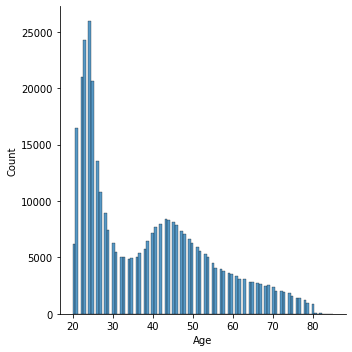

In [9]:
sns.displot(df['Age'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


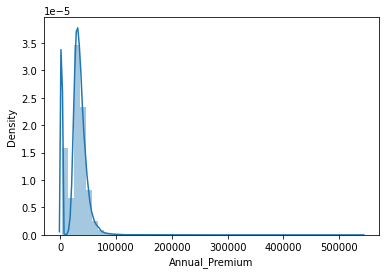

In [10]:
sns.distplot(df['Annual_Premium'])

In [11]:
def data_prep(df):

    df= df.drop(columns=['id','Policy_Sales_Channel','Vintage'])

    df=pd.get_dummies(df,columns=['Gender'] ,prefix='Gender')

    df=pd.get_dummies(df,columns=['Vehicle_Damage'] ,prefix='Damage')

    df=pd.get_dummies(df,columns=['Driving_License'] ,prefix='License')

    df=pd.get_dummies(df,columns=['Previously_Insured'] ,prefix='prev_insured')

    df["Age"] = pd.cut(df['Age'], bins=[0, 29, 35, 50, 100])

    df['Age']= df['Age'].cat.codes

    df['Annual_Premium'] = pd.cut(df['Annual_Premium'], bins=[0, 30000, 35000,40000, 45000, 50000, np.inf])

    df['Annual_Premium']= df['Annual_Premium'].cat.codes

    df['Vehicle_Age'] =df['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})

    df.drop(columns=['Region_Code'],inplace= True)

    return df
df1=data_prep(df)

In [12]:
df1.head()

,Age,Vehicle_Age,Annual_Premium,Response,Gender_Female,Gender_Male,Damage_No,Damage_Yes,License_0,License_1,prev_insured_0,prev_insured_1
0,2,2,3,1,0,1,0,1,0,1,1,0
1,3,1,1,0,0,1,1,0,0,1,1,0
2,2,2,2,1,0,1,0,1,0,1,1,0
3,0,0,0,0,0,1,1,0,0,1,0,1
4,0,0,0,0,1,0,1,0,0,1,0,1


In [13]:
Features= ['Age','Vehicle_Age','Annual_Premium',"Gender_Female","Gender_Male","Damage_No","Damage_Yes",
           "License_0","License_1" ,"prev_insured_0", "prev_insured_1"]

In [14]:
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(df1[Features],df1['Response'],
                                   test_size = 0.3, random_state = 101) 
X_train.shape,X_test.shape

((266776, 11), (114333, 11))

In [15]:
from imblearn.under_sampling import RandomUnderSampler

RUS = RandomUnderSampler(sampling_strategy=.5,random_state=3,)

X_train,Y_train  = RUS.fit_resample(df1[Features],df1['Response'])

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [16]:
def performance_met(model,X_train,Y_train,X_test,Y_test):
    acc_train=accuracy_score(Y_train, model.predict(X_train))
    f1_train=f1_score(Y_train, model.predict(X_train))
    acc_test=accuracy_score(Y_test, model.predict(X_test))
    f1_test=f1_score(Y_test, model.predict(X_test))
    print("train score: accuracy:{} f1:{}".format(acc_train,f1_train))
    print("test score: accuracy:{} f1:{}".format(acc_test,f1_test))

In [17]:
model = LogisticRegression()
model.fit(X_train,Y_train) 
performance_met(model,X_train,Y_train,X_test,Y_test)

train score: accuracy:0.7471847570113466 f1:0.6866392463845031
test score: accuracy:0.7187863521467993 f1:0.41871564940700023


In [18]:
model_DT=DecisionTreeClassifier(random_state=1) 
model_DT.fit(X_train,Y_train) 
performance_met(model_DT,X_train,Y_train,X_test,Y_test)

train score: accuracy:0.7578106044387355 f1:0.6603414800136111
test score: accuracy:0.7739410318980522 f1:0.43228045512454427


In [19]:
Forest= RandomForestClassifier(random_state=1) 
Forest.fit(X_train,Y_train) 
performance_met(Forest,X_train,Y_train,X_test,Y_test)

train score: accuracy:0.7578106044387355 f1:0.6604434305839035
test score: accuracy:0.7737573578931717 f1:0.43215595021184106


In [20]:
rf= RandomForestClassifier(random_state=1)

parameters = {'bootstrap': [True],
              'max_depth': [20, 25],
              'min_samples_leaf': [3, 4],
              'min_samples_split': [100,300],}

grid_search_1 = GridSearchCV(rf, parameters, cv=3, verbose=2, n_jobs=-1)
grid_search_1.fit(X_train, Y_train)
performance_met(grid_search_1,X_train,Y_train,X_test,Y_test)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.8min finished


train score: accuracy:0.7576964247484479 f1:0.6605889761890482
test score: accuracy:0.7736436549377695 f1:0.4324312469845168
